# Проект "Сегментирование пользователей по потреблению"

**Задача :**

Проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов, обращая особое внимание на отток.

**Цели :**

1. Узнать, что и в какой степени влияет на количество потребляемых продуктов
2. Узнать, как количество потребляемых продуктов влияет на отток
3. Сдеелать вывод об аудитории, потребляемой наибольшее и наименьшее количество продуктов.

## Материалы

Ссылка на дашборд: https://public.tableau.com/views/bank_project_16666507417200/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

Ссылка на презентацию: https://drive.google.com/file/d/1wf7DBhASl8UG6kpHMre4URyGLHI7YyDm/view?usp=sharing


##  1. Чтение и обработка данных

### 1.1 Импорт необходимых библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

### 1.2 Чтение файла

In [ ]:
bank = pd.read_csv('/content/bank_dataset.csv')
bank.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


### 1.3 Создание нового столбца с распределением по возрасту

In [ ]:
row=[]
def age_cat(row):
    x=row['Age']
    if x<=30:
      return 'молодой'
    elif x>30 and x<=55:
      return 'среднего возраста'
    else:
        return 'пожилой'
bank['age_cat']=bank.apply(age_cat, axis=1)
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
 12  age_cat           10000 non-null  object 
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


### 1.4 Приведение названия столбцов к нижнему регистру

In [ ]:
bank.columns = bank.columns.str.lower()
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
 12  age_cat           10000 non-null  object 
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


### 1.5 Проверка на наличие пропусков, дубликатов и корректности типа данных

Исходя из выше описанных пунктов, можем заметить, что все типы данных верные, пропуски есть только в столбце balance.

In [ ]:
#Проверим, влияет ли гендер клиента на наличие пропусков
bank.query('gender=="Ж"').info()
bank.query('gender=="М"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4543 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            4543 non-null   int64  
 1   score             4543 non-null   int64  
 2   city              4543 non-null   object 
 3   gender            4543 non-null   object 
 4   age               4543 non-null   int64  
 5   objects           4543 non-null   int64  
 6   balance           2889 non-null   float64
 7   products          4543 non-null   int64  
 8   creditcard        4543 non-null   int64  
 9   loyalty           4543 non-null   int64  
 10  estimated_salary  4543 non-null   float64
 11  churn             4543 non-null   int64  
 12  age_cat           4543 non-null   object 
dtypes: float64(2), int64(8), object(3)
memory usage: 496.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5457 entries, 5 to 9998
Data columns (total 13 columns):
 #   Column      

Заметим, что распределение пропусков по гендеру в процентном соотнощение приблизительно одинаковое. Значит, дело не в этом. 

In [ ]:
#Проверим, влияет ли отток на наличие пропусков
bank.query('churn==0').info()
bank.query('churn==1').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7963 entries, 1 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            7963 non-null   int64  
 1   score             7963 non-null   int64  
 2   city              7963 non-null   object 
 3   gender            7963 non-null   object 
 4   age               7963 non-null   int64  
 5   objects           7963 non-null   int64  
 6   balance           4846 non-null   float64
 7   products          7963 non-null   int64  
 8   creditcard        7963 non-null   int64  
 9   loyalty           7963 non-null   int64  
 10  estimated_salary  7963 non-null   float64
 11  churn             7963 non-null   int64  
 12  age_cat           7963 non-null   object 
dtypes: float64(2), int64(8), object(3)
memory usage: 871.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2037 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column      

Заметим, что в процентном соотношении больше пропусков среди тех, кто в итоге перестал быть клиентом банка, однако их так же много и среди тех, кто не попал в отток. 

In [ ]:
#Найдем все названия городов, в которых распалагаются отделения банка
pd.unique(bank['city'])

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [ ]:
#Проверим, влияет ли расположение банка на наличие пропусков
bank.query('city=="Ярославль"').info()
bank.query('city=="Рыбинск"').info()
bank.query('city=="Ростов Великий"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            5014 non-null   int64  
 1   score             5014 non-null   int64  
 2   city              5014 non-null   object 
 3   gender            5014 non-null   object 
 4   age               5014 non-null   int64  
 5   objects           5014 non-null   int64  
 6   balance           2596 non-null   float64
 7   products          5014 non-null   int64  
 8   creditcard        5014 non-null   int64  
 9   loyalty           5014 non-null   int64  
 10  estimated_salary  5014 non-null   float64
 11  churn             5014 non-null   int64  
 12  age_cat           5014 non-null   object 
dtypes: float64(2), int64(8), object(3)
memory usage: 548.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 9992
Data columns (total 13 columns):
 #   Column      

Заметим, что в Ростове Великом не ни одного пропуска, в то время как в остальных городах приблизительно половина пропусков в столбце balance. Тут явно дело в отделениях банка в конкретных городах. 

In [ ]:
#Проверим, влияет ли расположение банка на наличие пропусков
bank.query('age_cat=="молодой"').info()
bank.query('age_cat=="среднего возраста"').info()
bank.query('age_cat=="пожилой"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1968 entries, 7 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            1968 non-null   int64  
 1   score             1968 non-null   int64  
 2   city              1968 non-null   object 
 3   gender            1968 non-null   object 
 4   age               1968 non-null   int64  
 5   objects           1968 non-null   int64  
 6   balance           1198 non-null   float64
 7   products          1968 non-null   int64  
 8   creditcard        1968 non-null   int64  
 9   loyalty           1968 non-null   int64  
 10  estimated_salary  1968 non-null   float64
 11  churn             1968 non-null   int64  
 12  age_cat           1968 non-null   object 
dtypes: float64(2), int64(8), object(3)
memory usage: 215.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7232 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column      

Заметим, что в основном в процентном соотношении пропуски у людей среднего возраста. Возможно, дело так же в этом.  Точную причину пропусков надо узнавать у самого заказчика.

Так как точную причину наличия пропусков мы не знаем, то заполнять их не будем

In [ ]:
#проверим на наличие дубликатов
bank.duplicated().sum()

0

Дубликатов нет

### 1.6 Проверка на выбросы

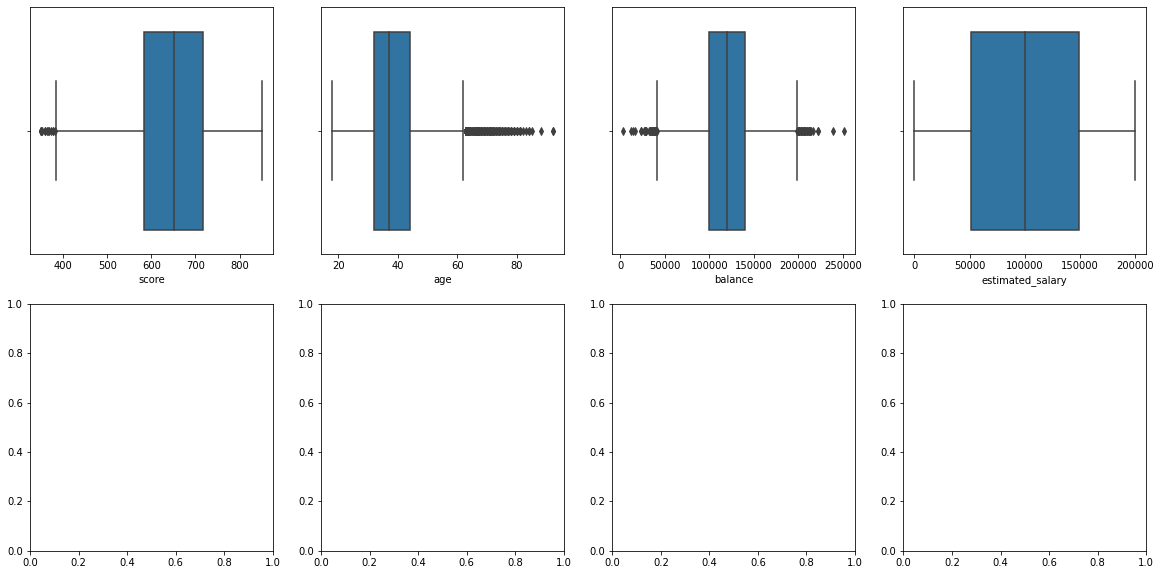

In [ ]:
#Выведем графики выбросов
a=['age', 'score', 'balance', 'estimated_salary']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axes_list = [item for sublist in axes for item in sublist]
for column in bank.columns:
    if column in a:
      ax = axes_list.pop(0)
      sns.boxplot(x=bank[column], ax=ax)

Здесь выбросом считается возраст, более либо равный 61-62, менее 350 баллов в значении score, менее 40000 и более 200000 в столбце баланса. В столбце зарплаты выбросов нет.


После исследования столбцов на выбросы, делаю вывод, что удалять их не будем.

## 2. Проведение исследовательского анализа данных

### 2.1 Проверить взаимосвязь между количеством приобретенных продуктов и остальными критериями

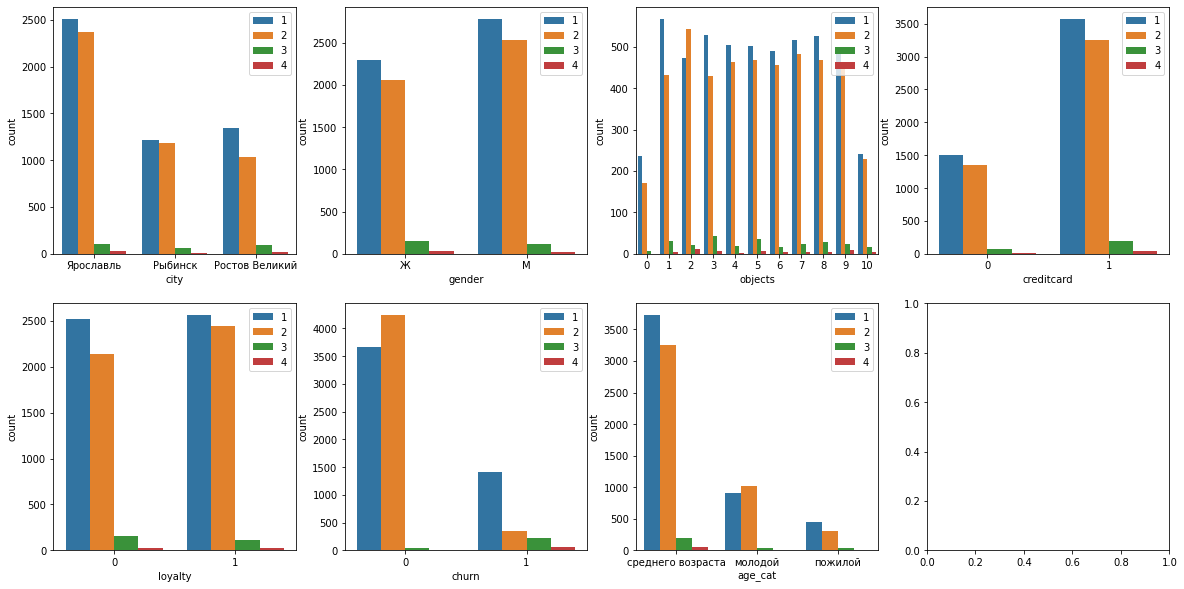

In [ ]:
#Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
distplot_columns=bank[['userid', 'products', 'age', 'score', 'estimated_salary', 'balance']]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axes_list = [item for sublist in axes for item in sublist]
for column in bank.columns:
    if column not in distplot_columns:
        ax = axes_list.pop(0)
        sns.countplot(x = bank[column], hue='products', data=bank, ax=ax)
        ax.legend(['1', '2', '3', '4'])

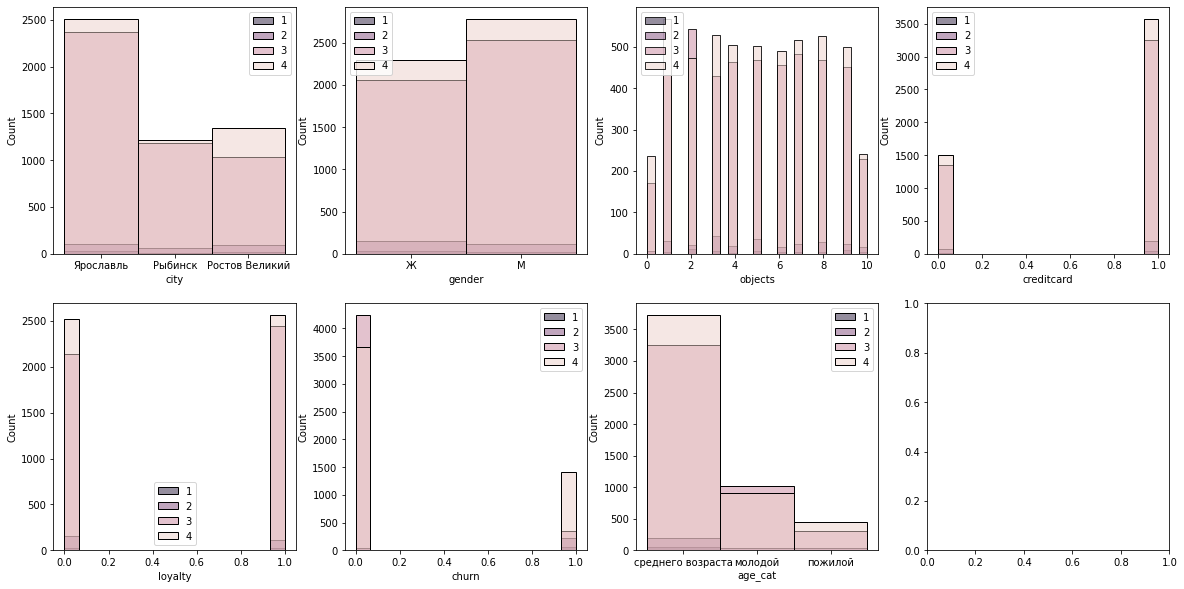

In [ ]:
distplot_columns=bank[['userid', 'products', 'age', 'score', 'estimated_salary', 'balance']]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axes_list = [item for sublist in axes for item in sublist]
for column in bank.columns:
    if column not in distplot_columns:
        ax = axes_list.pop(0)
        sns.histplot(x = bank[column], hue='products', data=bank, ax=ax)
        ax.legend(['1', '2', '3', '4'])

In [ ]:
bank['index'] = np.arange(bank.shape[0])
bank_new = pd.get_dummies(bank['city']).reset_index()
bank = bank.merge(bank_new, how='left', on='index')
bank_n = pd.get_dummies(bank['gender']).reset_index()
bank = bank.merge(bank_n, how='right', on='index')
bank

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,age_cat,index,Ростов Великий,Рыбинск,Ярославль,Ж,М
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,среднего возраста,0,0,0,1,1,0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,среднего возраста,1,0,1,0,1,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,среднего возраста,2,0,0,1,1,0
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,среднего возраста,3,0,0,1,1,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,среднего возраста,4,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0,среднего возраста,9995,0,0,1,0,1
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0,среднего возраста,9996,0,0,1,0,1
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1,среднего возраста,9997,0,0,1,1,0
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1,среднего возраста,9998,1,0,0,0,1


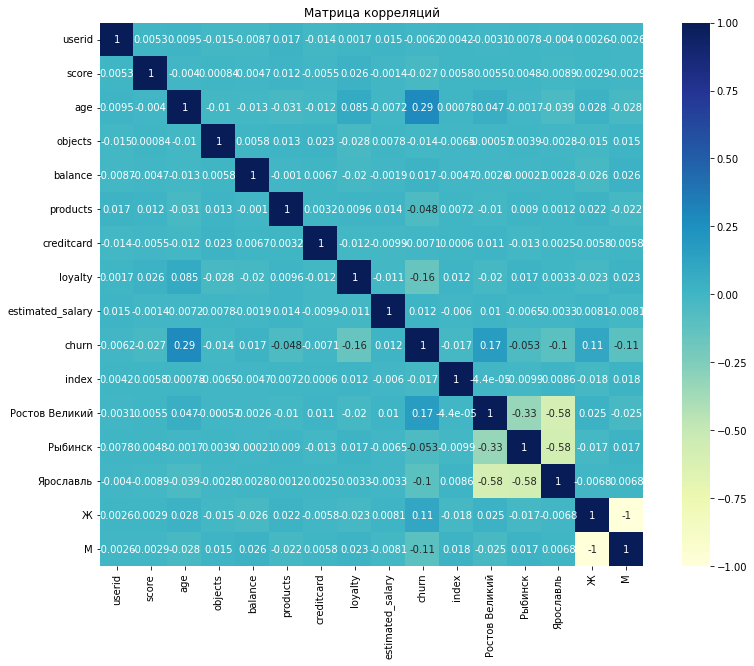

In [ ]:
#Построим матрицу корреляций
plt.figure(figsize=(14,10))
sns.heatmap(data = bank.corr(), annot=True, square=True, cmap='YlGnBu')
plt.title('Матрица корреляций')
plt.show()

### 2.2 Сформулировать промежуточный вывод

Исходя из выше проделанной работы, можем сказать, что явной взаимосвязи между количеством купленных продуктов и остальными критериями нет

##  3. Сегментация

### 3.1 Сегментируем покупателей по количеству купленных продуктов

In [ ]:
bank.query('products==1').describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,index,Ростов Великий,Рыбинск,Ярославль,Ж,М
count,5.084000e+03,5084.000000,5084.000000,5084.000000,4179.000000,5084.0,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000,5084.000000
mean,1.573237e+07,649.120968,39.673092,4.974626,119894.163723,1.0,0.703777,0.504131,99487.256851,0.277144,4972.034225,0.265342,0.240165,0.494493,0.451613,0.548387
std,7.216578e+04,97.203710,10.659566,2.914269,29804.134035,0.0,0.456636,0.500032,57363.626412,0.447632,2883.184757,0.441559,0.427226,0.500019,0.497702,0.497702
min,1.560844e+07,350.000000,18.000000,0.000000,12459.190000,1.0,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.566940e+07,581.000000,32.000000,2.000000,100440.185000,1.0,0.000000,0.000000,50414.515000,0.000000,2486.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573206e+07,651.000000,38.000000,5.000000,119919.120000,1.0,1.000000,1.000000,99226.830000,0.000000,4937.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.579434e+07,717.000000,45.000000,7.000000,139442.110000,1.0,1.000000,1.000000,148212.695000,1.000000,7443.500000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585843e+07,850.000000,92.000000,10.000000,238387.560000,1.0,1.000000,1.000000,199970.740000,1.000000,9999.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
bank.query('products==1').groupby('age_cat')['userid'].count()

age_cat
молодой               910
пожилой               447
среднего возраста    3727
Name: userid, dtype: int64

Охарактеризуем людей, преобретающих 1 продукт:
1. Средний возраст - 40 лет
2. Среднее количество объектов в собственности - 5
3. Средний баланс - 120000
4. Приблизительно у 70% клиентов есть кредитная карта
5. Половина пользователей активна
6. Средняя заработная плата - 99000 
7. Отток составляет **28%**

In [ ]:
bank.query('products==2').describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,index,Ростов Великий,Рыбинск,Ярославль,Ж,М
count,4.590000e+03,4590.000000,4590.000000,4590.000000,1990.000000,4590.0,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000,4590.000000
mean,1.573484e+07,652.188671,37.753595,5.051852,119660.944362,2.0,0.707190,0.532898,100452.012821,0.075817,5036.120479,0.226580,0.257734,0.515686,0.448802,0.551198
std,7.156542e+04,96.066831,10.145663,2.867741,30647.376666,0.0,0.455102,0.498971,57790.799984,0.264734,2895.285983,0.418664,0.437435,0.499808,0.497426,0.497426
min,1.560845e+07,350.000000,18.000000,0.000000,3768.690000,2.0,0.000000,0.000000,90.070000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567420e+07,586.000000,31.000000,3.000000,99179.367500,2.0,0.000000,0.000000,50797.287500,0.000000,2514.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573578e+07,653.000000,36.000000,5.000000,119762.245000,2.0,1.000000,1.000000,100738.855000,0.000000,5067.500000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.579700e+07,719.000000,42.000000,7.000000,139556.932500,2.0,1.000000,1.000000,150151.460000,0.000000,7580.250000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.585838e+07,850.000000,92.000000,10.000000,214346.960000,2.0,1.000000,1.000000,199992.480000,1.000000,9998.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
bank.query('products==2').groupby('age_cat')['userid'].count()

age_cat
молодой              1025
пожилой               310
среднего возраста    3255
Name: userid, dtype: int64

Охарактеризуем людей, преобретающих 2 продукта:
1. Средний возраст - 38 лет - что является **самым маленьким показателем**
2. Среднее количество объектов в собственности - 5
3. Средний баланс - 120000
4. Приблизительно у 70% клиентов есть кредитная карта
5. 53% пользователей активны - **самый большой показатель**
6. Средняя заработная плата - 100000 
7. Отток составляет **7%** - что является **самым маленьким показателем**

In [ ]:
bank.query('products==3').describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,index,Ростов Великий,Рыбинск,Ярославль,Ж,М
count,2.660000e+02,266.000000,266.000000,266.000000,168.000000,266.0,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,1.574182e+07,648.105263,43.195489,5.003759,119475.686310,3.0,0.714286,0.424812,104318.130564,0.827068,4853.135338,0.360902,0.248120,0.390977,0.560150,0.439850
std,7.395279e+04,95.190396,10.422008,2.879332,31504.871935,0.0,0.452606,0.495246,55464.281426,0.378902,2853.735510,0.481168,0.432736,0.488889,0.497304,0.497304
min,1.560905e+07,358.000000,21.000000,0.000000,43772.660000,3.0,0.000000,0.000000,3440.470000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.568224e+07,586.000000,36.000000,3.000000,100741.587500,3.0,0.000000,0.000000,64344.800000,1.000000,2423.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.574438e+07,650.000000,42.000000,5.000000,118118.190000,3.0,1.000000,0.000000,101046.885000,1.000000,5069.500000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.580754e+07,711.000000,50.000000,8.000000,139714.815000,3.0,1.000000,1.000000,152230.195000,1.000000,7235.500000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585823e+07,850.000000,77.000000,10.000000,250898.090000,3.0,1.000000,1.000000,199357.240000,1.000000,9895.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
bank.query('products==3').groupby('age_cat')['userid'].count()

age_cat
молодой               31
пожилой               35
среднего возраста    200
Name: userid, dtype: int64

Охарактеризуем людей, преобретающих 3 продукта:
1. Средний возраст - 43 года
2. Среднее количество объектов в собственности - 5
3. Средний баланс - 119000
4. Приблизительно у 71% клиентов есть кредитная карта
5. 42% пользователей активны
6. Средняя заработная плата - 104000 
7. Отток составляет **82%**

In [ ]:
bank.query('products==4').describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,index,Ростов Великий,Рыбинск,Ярославль,Ж,М
count,6.000000e+01,60.000000,60.000000,60.000000,46.000000,60.0,60.000000,60.000000,60.000000,60.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.571936e+07,653.583333,45.683333,5.300000,122260.610870,4.0,0.683333,0.483333,104763.723333,1.0,5174.183333,0.400000,0.116667,0.483333,0.633333,0.366667
std,6.814840e+04,101.265600,8.619040,2.947564,27761.150772,0.0,0.469102,0.503939,57526.494114,0.0,2717.959089,0.494032,0.323732,0.503939,0.485961,0.485961
min,1.561074e+07,376.000000,29.000000,1.000000,46870.430000,4.0,0.000000,0.000000,5669.310000,1.0,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.566638e+07,595.000000,40.000000,2.750000,112063.295000,4.0,0.000000,0.000000,62033.390000,1.0,2616.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.570775e+07,643.000000,45.000000,5.000000,120968.270000,4.0,1.000000,0.000000,112163.105000,1.0,4785.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.576341e+07,708.000000,50.250000,8.000000,135527.207500,4.0,1.000000,1.000000,139371.955000,1.0,7599.750000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585805e+07,850.000000,68.000000,10.000000,195238.290000,4.0,1.000000,1.000000,198874.520000,1.0,9565.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
bank.query('products==4').groupby('age_cat')['userid'].count()

age_cat
молодой               2
пожилой               8
среднего возраста    50
Name: userid, dtype: int64

Охарактеризуем людей, преобретающих 4 продукта:
1. Средний возраст - 45 лет - **самый большой показатель**
2. Среднее количество объектов в собственности - 5
3. Средний баланс - 122000 - **самый большой показатель**
4. Приблизительно у 68% клиентов есть кредитная карта
5. 48% пользователей активны
6. Средняя заработная плата - 105000 
7. Отток составляет **100%** - **самый большой показатель**

### 3.2 Охарактеризуем каждую группу и сделаем выводы

Охарактеризуем каждую группу:
Так как молодые в основном покупают 2 продукта, пожилые - 1, а люди среднего возраста - 2 (при этом доля людей среднего возраста во всех группах большая), думаю, что банк выпускает банковские карты, выдаёт кредиты и ипотеку. Всем 4 продуктами в подавляющем большинстве пользуются люди среднего возраста, так что предположу, что 4 продукт - открытие своего вклада.

Не могу сказать, что тут есть явное деление на группы, так как показатели в основном +- одинаковые, но предположу, что наши группы можно охарактеризовать так:
1. 1 группа - в основном это те, кто просто завел банковскую карточку. Здесь есть как молодёжь, так и люди среднего возраста, пенсионеры. Средний доход достаточно большой, так что думаю, что даже если и есть среди клиентов студенты, они в основном работают.
2. 2 группа - думаю, в основном, это те, кто берут кредит и банковскую карту. У этих людей зарплата чуть побольше, но в целом, ключевой факт - наличие кредита
3. 3 группа - в основном это те, кто взял ипотеку, кредит и банковскую карту. Ключевое здесь - ипотека. У них больше зарплата, остальные критерие приблизительно такие же
4. 4 группа - это те, кто купил все 4 продукта. Думаю, тогда явно проблемы с вкладами





Сделаем некоторые выводы:
1. Люди, которые покупают 2 продукта, самые активные и с меньшей вероятностью попадают в отток
2. Люди, которые покупают 4 продукта со 100% вероятностью попадают в отток. В этом явно кроется проблема. Возможно какие-то продукты некачественны.
3. Есть взаимосвязь между зарплатой и количеством купленных продуктов: чем больше зарплата, тем больше покупок сделано

## 4. Проверка гипотез

### 4.1 Проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

H0: Нет статистически значимой разницы в зарплате среди тех, кто купил 1 продукт и кто купил 2 продукта

H1: Есть статистически значимая разница в зарплате среди тех, кто купил 1 продукт и кто купил 2 продукта

In [ ]:
gr_1=bank.query('products==1')
gr_2=bank.query('products==2')

alpha = .05
results = st.ttest_ind(
    gr_1['estimated_salary'], 
    gr_2['estimated_salary'])# ваш код: проверьте гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.41047183624949335
Не получилось отвергнуть нулевую гипотезу


### 4.2 Сформулировать и проверить статистическую гипотезу относительно представленных данных.

H0: Среди тех, кто приобретает менее 3 товаров, и тех, кто приобретает более 2 товаров, нет статистической разницы в количестве людей, ушедших в отток

H1: Среди тех, кто приобретает менее 3 товаров, и тех, кто приобретает более 2 товаров, есть статистическая разница в количестве людей, ушедших в отток

In [ ]:

alpha = 0.05
count_3= bank.query('products<=2')['churn'].sum()
count_4= bank.query('products>2')['churn'].sum()
nobs_3 = bank.query('products<=2')['userid'].count()
nobs_4 = bank.query('products>2')['userid'].count()
count = np.array([count_3, count_4])
nobs = np.array([nobs_3, nobs_4])
stat, pval = proportions_ztest(count, nobs)
print('p-value:', pval)
if pval < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 5.837170492919339e-196
Отвергаем нулевую гипотезу


Вывод:
1. Количество людей, ушедших в отток, зависит от того, сколько продуктов у банка они купили
2. Люди, покупающие 1 и 2 продукта, имеет приблизительно одинаковое распределение в зарплате

## 5. Выводы

Выводы: 
1. У людей, которые покупали 1 и 2 продукта, приблизительно одинаковое распределение заработных плат.
2. У тех, кто купил 2 продукта, процент оттока намного меньше
3. Особой взаимосвязи между количеством купленных продуктов и разными признаками не наблюдается

Рекомендации:
1. Можем заметить, что у тех, кто покупал все 4 продукта, процент оттока - 100%. Скорее всего проблема в одном из продуктов: возможно, там слишком дорогое обслуживание или много недоработок
2. Наибольший процент оттока можно наблюдать у людей среднего возраста. Нужно обратить внимание на этот пласт клиентов. Такие люди обычно часто берут кредиты. Возможно, дело именно в кредитовании. Думаю, стоит устроить соц. опрос с обратной связью.

По группам:
1. Первой группе могу предложить создание мобильного приложения, куда можно было бы добавить какие-нибудь новые функции 
2. Второй группе рекомендую добавить более комфортную условия по закрытию кредита (к примеру, уменьшить процент кредитования)
3. Третьей группе советую добавить более выгодные условия по ипотеке 
4. Для четвертой группы следует сделать соц. опрос с обратной связью, чтобы понять, где какие проблемы кроются, и в особенности надо обратить внимание на вклады

Конкретнее описание групп можно посмотреть в пункте 3.1